In [ ]:
# Generic stuff
import time
import os, sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d
from copy import deepcopy

import torch
from sbi import utils as utils
from sbi.inference.base import infer
from sbi import analysis as analysis

    
# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt

# CTWC model code
sys.path.append('../ctwc')

from ctwc_model_DP import run_net_sim

filename = "samples_fit_Gs.npy"

N_RUNS = 3
N_SIMULATIONS = 5
Gs = np.arange(0.0, 2.1, 0.5)

T = 2**12
dt = 0.1


In [ ]:
path = '/home/docker/packages/tvb-multiscale/examples/data/cerebellum/PS_popa2013'
psd_m1 = np.load(os.path.join(path, "PSD_M1.npy"))
psd_s1 = np.load(os.path.join(path, "PSD_S1.npy"))

In [ ]:
f = np.arange(5.0, 48.0, 1.0)
psd_m1_targ = np.interp(f, psd_m1[:, 0], psd_m1[:, 1])
psd_s1_targ = np.interp(f, psd_s1[:, 0], psd_s1[:, 1])
psd_targ = (psd_m1_targ + psd_s1_targ) / 2
psd_targ_norm = psd_targ / psd_targ.sum()


Text(0, 0.5, 'log(PS)')

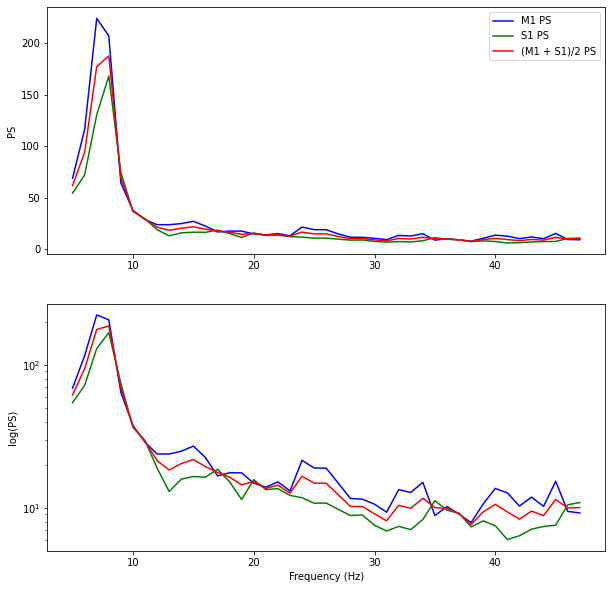

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(f, psd_m1_targ, "b", label='M1 PS')
axes[0].plot(f, psd_s1_targ, "g", label='S1 PS')
axes[0].plot(f, psd_targ, "r", label='(M1 + S1)/2 PS')
axes[0].set_ylabel('PS')
axes[0].legend()
axes[1].semilogy(f, psd_m1_targ, "b", label='M1 PS')
axes[1].semilogy(f, psd_s1_targ, "g", label='S1 PS')
axes[1].semilogy(f, psd_targ, "r", label='(M1 + S1)/2 PS')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('log(PS)')


In [ ]:
# # 1-node weights & delays
# weights = np.array([[1.]])
# delays = np.array([[10.]])

def prepare_params(g=0.0):
    
    # 2-nodes' weights & delays
    weights = np.array([[0.0, 1.0], [1.0, 0.0]])
    delays = np.array([[0.0, 10.0], [10.0, 0.0]])

    sc = 1/dt

    #g = 0.0  # 5.0
    I_o = -0.25

    stim_amp = 0.25                        #stimulation amplitude
    i_e = -0.35 #  -1.0 # -0.75            #constant current of excittory population 
    i_th = 0.5 + I_o                       #consant current of thalamic exitatory populatin 
    wie = -3.0 # -4.0 # -2.0 #  -3.0 #     #inhibitory coupling for the cortical population
    wrtnth = -2.                           #inhibitory coupling for the thalamic population
    a_e = 0.9/sc # 0.3  # 0.9 #            #Time constants , the higher those number are the faster is the system 
    a_i = 0.9/sc # 0.5  # 0.9 #
    a_th = 0.25/sc # 0.2 # 0.25 #
    a_rtn = 0.25/sc # 0.2 # 0.25 #
        
    wee = 1.4 # 0.5 # 1.4 #
    wei = 1.4 # 1.0 # 1.4 #
    
    noise = 1e-4  # 1e-5

    ssX_params = dict(I_o=0.0,
                      wee = wee,
                      wei = wei,
                      wie = wie, 
                      wii = -0.5, # wie = -2.,wii = -0.5,
                      wertn = 0.6, weth = .6, wthi = 0.2, wthe = 1.65, wrtnth = wrtnth, wthrtn = 2.,
                      D_e = noise,D_i= noise,D_th = noise,D_rtn = noise,
                      T=int(sc*T), #T = 1024*4,# 20,
                      P=1,Q = 1, Dt = 0.001/sc,
                      dt = 0.1, gain = 20., threshold = 0., Pi = 3.14159,
                      g = g, # 10., # 1., #-0.9,
                      a_e = a_e, 
                      a_i = a_i, 
                      a_th=a_th, 
                      a_rtn=a_rtn, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
                      i_e = i_e,
                      i_i = -0.3, 
                      i_th = i_th, 
                      i_rtn = -0.8,
                      tau1 = sc*20.,
                      tau2 = sc*5., 
                      T_transient=int(sc*1000),
                      stim_amp=stim_amp, 
                      stim_freq=6.0, stim_type='sinewave', stim_pops=['th'],
                      weights=weights,
                      delays=delays,
                      K=weights.shape[0], #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
                      return_ts=True,
                      compute_connectivity=False ,
                      f=f
                     )#True) #False
    
    priors_params = dict(zip(["stim_amp", "i_e", "i_th", "wie", "wrtnth", "a_e", "a_i", "a_th", "a_rtn"], 
                             [stim_amp, i_e, i_th, wie, wrtnth, a_e, a_i, a_th, a_rtn]))
    
    return ssX_params, priors_params



In [ ]:
def run_sim_for_sbi(priors, priors_params_names, params={}, return_ts=False):
    
    p = params.copy()
    
    for prior, pname in zip(priors, priors_params_names):  # 'noise'             
        try:
            numpy_prior = prior.numpy()
        except:
            numpy_prior = prior  
        if pname == 'noise':
            for noise in ['D_e', 'D_i', 'D_th','D_rtn']:
                p[noise] = 10**numpy_prior
        else:
            p[pname] = numpy_prior

    f = p.pop('f')
    
    res = run_net_sim(**p)
    
    # Periodogram PS:
    ssX_pps = res[2].copy()
    ssX_pps = ssX_pps['e'].loc[f[0]:f[-1] + 1.0].mean(axis=1)
    ssX_pps = np.interp(f, ssX_pps.index.values, ssX_pps.values)
    ssX_pps = ssX_pps / ssX_pps.sum()
    
    # Time series
    if return_ts:
        ssX_ts = res[0].copy()
        ssX_ts.columns= ssX_ts.columns.swaplevel(0)
        ssX_ts = ssX_ts[0]
        return  ssX_pps, ssX_ts 
    else:
        return  ssX_pps
    
    
def model_sbi_fit(iG):
    
    g = Gs[iG]
    
    ssX_params, priors_params = prepare_params(g)
    priors_params_names = list(priors_params.keys())
    run_sim_for_sbi_for_g = lambda priors: run_sim_for_sbi(priors, priors_params_names, 
                                                           params=ssX_params, return_ts=False)
    
    print("\n\nFitting for G = %g!\n" % g)
  #     # uniform priors: g
#     g_prior_min = [0.0]  # 
#     g_prior_max = [2.0]  # 
#     g_priors = utils.torchutils.BoxUniform(low=torch.as_tensor(g_prior_min), 
#                                          high=torch.as_tensor(g_prior_max))
    
    # normal priors:
    #             0.   1.     2.     3.     4.     5.    6.    7.      8.  
    #        stim_amp, i_e,   i_th,  wie,  wrtnth, a_e,  a_i,  a_th,  a_rtn
    prior_min = [0.1, -1.0,   0.0, -10.0, -5.0,   0.03, 0.03, 0.01,  0.01]  # 
    prior_max = [0.5,  0.0,   1.0,  0.0,   0.0,   0.15, 0.15, 0.05,  0.05]  # 
#     
    prior_loc = [0.25, -0.5,  0.5,  -5.0,  -2.5,  0.09, 0.09, 0.025, 0.025]  # #Question :What those prameters refers to ?
    prior_sc =  [0.1,   0.25, 0.25,  2.5,   1.25, 0.03, 0.03, 0.005, 0.005]  # , 0.5 #loc ==>location of the center of the distibution
    #prior_sc : refers to the scale how much the distribution is stretched around the center prior_loc 'variance'
    
    n_priors = len(prior_min)
    
    priors_normal = torch.distributions.Normal(loc=torch.as_tensor(prior_loc), 
                                               scale=torch.as_tensor(prior_sc)) #create a gaussian normal distribution 
#with parameters loc :The Location paramet tells you where the distribution is centered on the horizontal axis.
#The Scale parameter gives you an idea of the scale on the horizontal axis. For example, the scale parameter on a standard normal distribution is equal to one standard deviation (σ).
#It usually stretches or squeezes a graph

#     priors = torch.distributions.MultivariateNormal(loc=torch.as_tensor(prior_loc), 
#                                                     scale_tril=torch.diag(torch.as_tensor(prior_sc)))
    priors = torch.distributions.Independent(priors_normal, 1) #Me :useful for changing the shape of the result
    
    #samples_fit =torch.Tensor()
   # posterior =torch.Tensor()
    for iR in range(N_RUNS):
        tic = time.time()
    #priors : a prior distribution that allows to sample parameter sets
    #run_sim_for_sbi_for_g :a simulator that takes parameter sets and produces simulation outputs
        posterior= infer(run_sim_for_sbi_for_g, 
                      priors, method='SNPE', num_simulations=N_SIMULATIONS, num_workers=5) #posterior prob p(teta/x)
        print("Done in %g sec!" % (time.time() - tic))
    
        print("\nSampling posterior...")

        if iR:
            samples_fit = torch.cat((samples_fit, posterior.sample((10000,), x=psd_targ_norm)), 0)
        else:
            samples_fit = posterior.sample((10000,), x=psd_targ_norm) 
        
        if os.path.isfile(filename):
            samples_fit_Gs = np.load(filename, allow_pickle=True).item()
        else:
            samples_fit_Gs = {}
        samples_fit_Gs[g] = {}
        samples_fit_Gs[g]['samples'] = samples_fit.numpy()
        samples_fit_Gs[g]['mean'] = samples_fit.mean(axis=0).numpy()
        np.save(filename, samples_fit_Gs, allow_pickle=True)
    
        print("\nPlotting posterior...")
        limits = []
        for pmin, pmax in zip(prior_min, prior_max):
            limits.append([pmin, pmax])
        fig, axes = analysis.pairplot(samples_fit,
                                  limits=limits,
                                  ticks=limits,
                                  figsize=(10,10),
                                  points=np.array(list(priors_params.values())),  # , -4
                                  points_offdiag={'markersize': 6},
                                  points_colors=['r']*n_priors);
                  
        print("\nSimulating with posterior means...")
        ssX_pps, ssX_ts = run_sim_for_sbi(samples_fit_Gs[g]['mean'], priors_params_names, 
                                      ssX_params, return_ts=True)
                    
    f = ssX_params['f']
    fig1, axes1 = plt.subplots(2, 1, figsize=(10, 10))
    # ssX_pps = ssX_pps / ssX_pps.sum()
    axes1[0].plot(f, ssX_pps, "b", label='Simulation')
    axes1[0].plot(f, psd_targ_norm, "r", label='Target')
    axes1[0].set_ylabel('PSD')
    axes1[0].legend()
    axes1[1].semilogy(f, ssX_pps, "b", label='Simulation')
    axes1[1].semilogy(f, psd_targ_norm, "r", label='Target')
    axes1[1].set_xlabel('Frequency (Hz)')
    axes1[1].set_ylabel('log(PSD)')
    
    time_vals = ssX_ts['e'].index.values
    fig2, axes2 = plt.subplots(4, 1, figsize=(20, 10))
    ssX_ts['e'].plot(ax=axes2[0])
    me = ssX_ts['e'].mean()
    axes2[0].plot([time_vals[0], time_vals[-1]], [me]*2, 'r')
    axes2[0].set_title('e\nm=%g' % me)
    ssX_ts['i'].plot(ax=axes2[1])
    mi = ssX_ts['i'].mean()
    axes2[1].plot([time_vals[0], time_vals[-1]], [mi]*2, 'r')
    axes2[1].set_title('i\nm=%g' % mi)
    ssX_ts['th'].plot(ax=axes2[2])
    mth = ssX_ts['th'].mean()
    axes2[2].plot([time_vals[0], time_vals[-1]], [mth]*2, 'r')
    axes2[2].set_title('th\nm=%g' % mth)
    ssX_ts['rtn'].plot(ax=axes2[3])
    mrtn = ssX_ts['rtn'].mean()
    axes2[3].plot([time_vals[0], time_vals[-1]], [mrtn]*2, 'r')
    axes2[3].set_title('rtn\nm=%g' % mrtn)
    axes2[3].set_xlabel('Time (ms)')
    fig2.tight_layout()
                                  
    return samples_fit_Gs, ((fig, axes), (fig1, axes1), (fig2, axes2))
    

In [ ]:
samples = []
figs = []




Fitting for G = 0!



Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 82 epochs.Done in 165.017 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 96 epochs.Done in 146.731 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 79 epochs.Done in 153.849 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


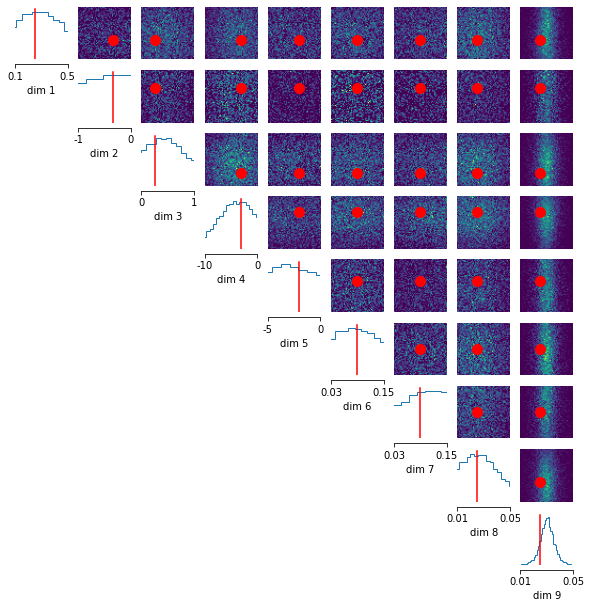

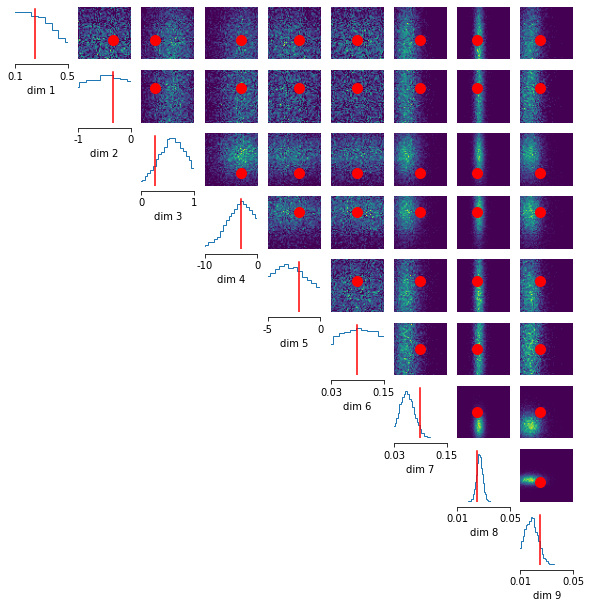

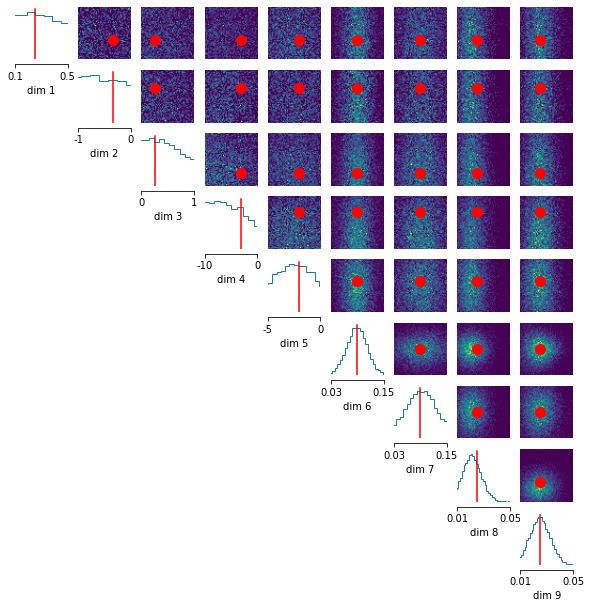

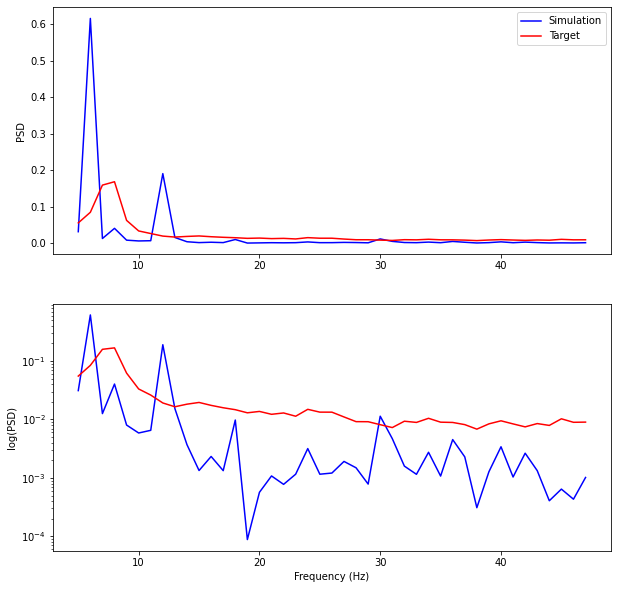

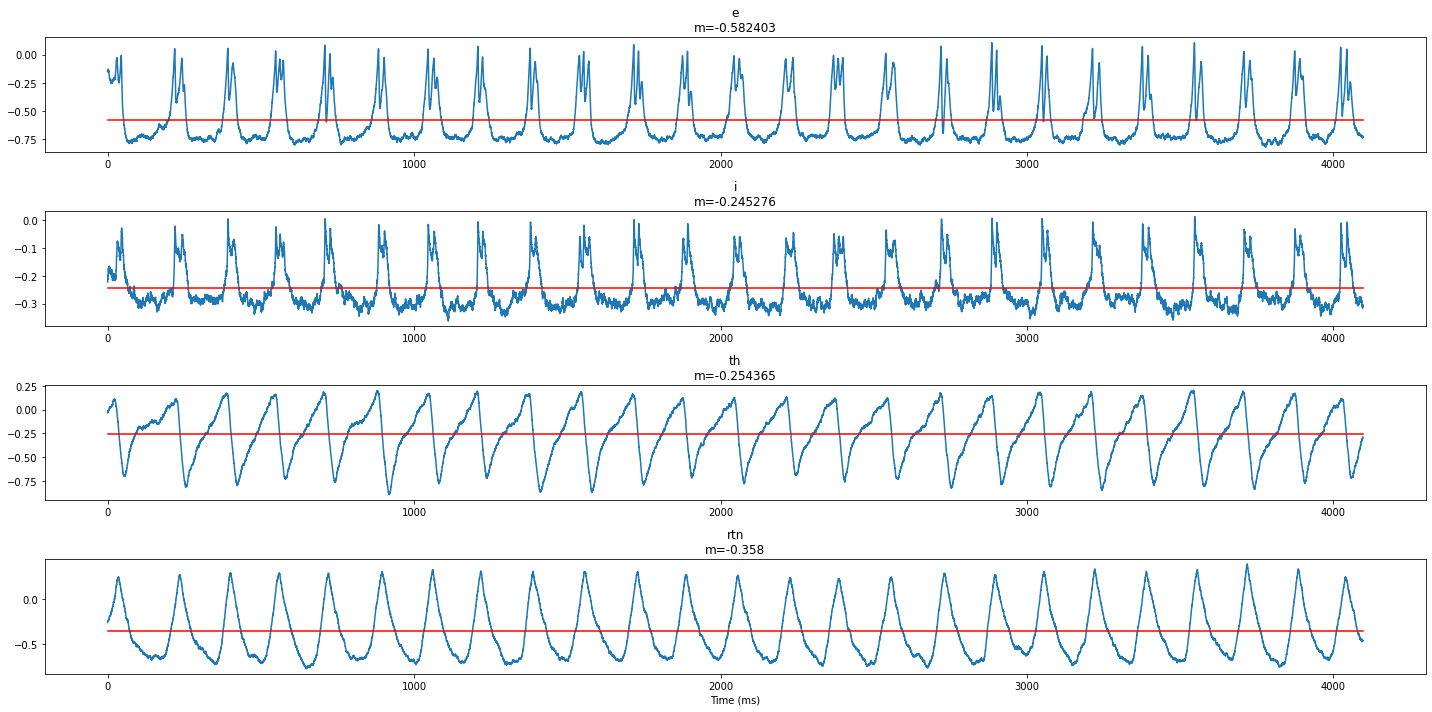

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(0)
samples.append(samples_fit_Gs)
figs.append(figaxes)

In [ ]:
print(samples)

In [ ]:
print(samples_fit_Gs[0])

{'samples': array([[-0.02062694, -0.67859983,  1.1649594 , ..., -0.05328647,
         0.01106005,  0.01414824],
       [ 0.30302295,  0.38658684,  0.64925724, ..., -0.01350835,
         0.05837606,  0.00474841],
       [-0.06626413,  1.3330505 ,  0.66957515, ...,  0.00409123,
         0.07549944, -0.01309809],
       ...,
       [ 0.18313748, -0.3908261 ,  1.0508782 , ..., -0.00895857,
         0.02852894,  0.00535662],
       [ 0.23595752, -1.0121773 ,  0.75013065, ...,  0.06359975,
         0.00156223,  0.026245  ],
       [ 0.36786732, -0.78539133,  0.793293  , ...,  0.01302136,
         0.00924882,  0.01966358]], dtype=float32), 'mean': array([ 0.24977061, -0.42873314,  0.8290415 , -6.8676844 , -2.3875508 ,
        0.09116719,  0.05878877,  0.02397261,  0.02889283], dtype=float32)}


In [ ]:
print(samples_fit_Gs[0]["samples"].shape)

(10000, 9)




Fitting for G = 0.5!



Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 110 epochs.Done in 154.815 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


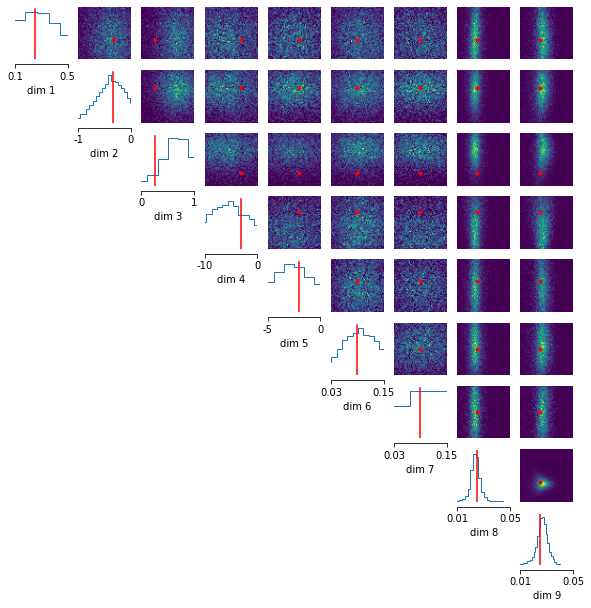

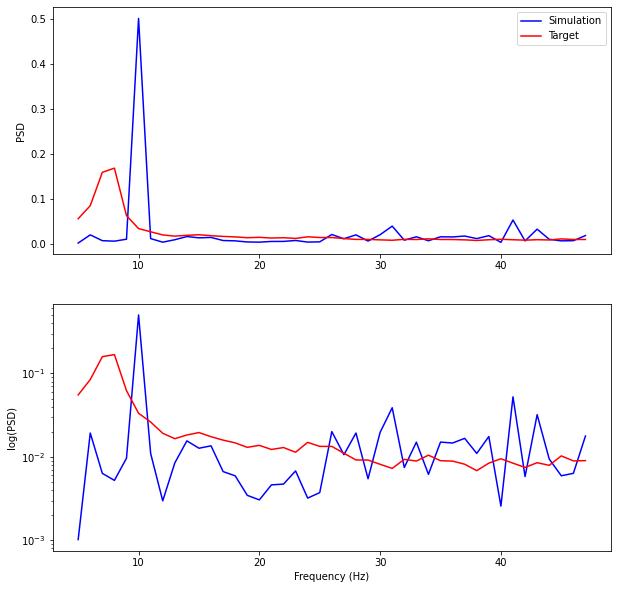

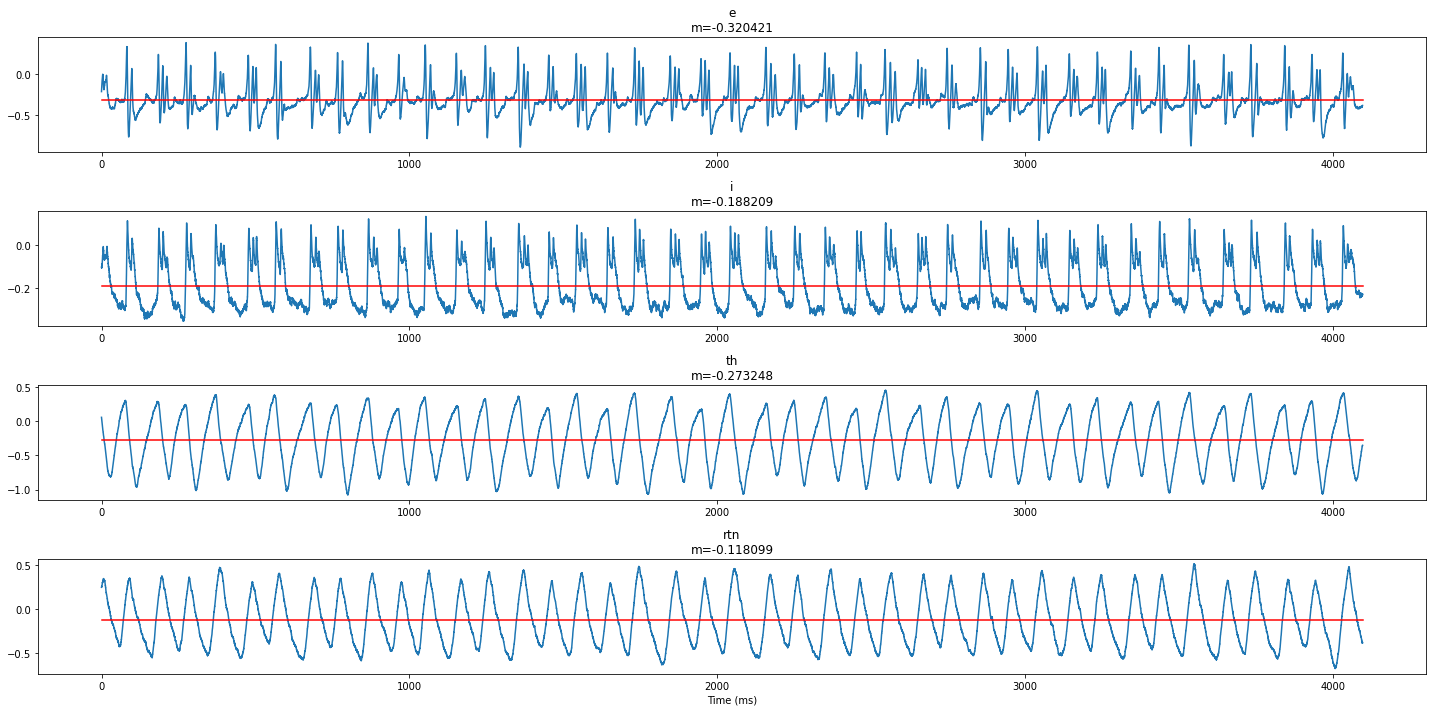

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(1)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 1!



Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 96 epochs.Done in 170.91 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


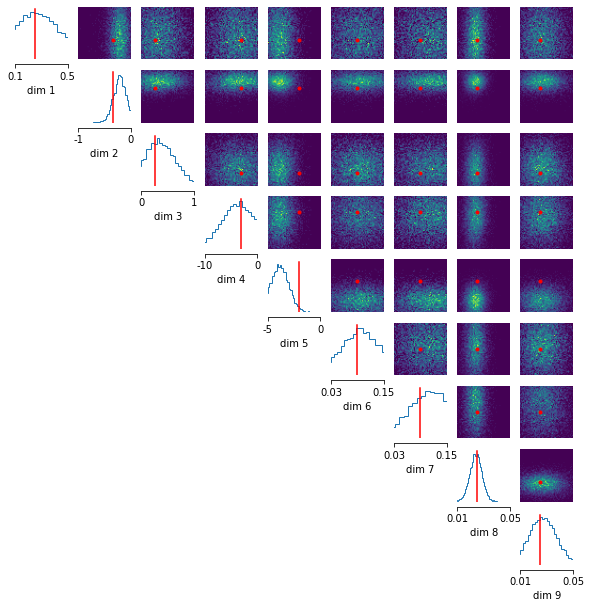

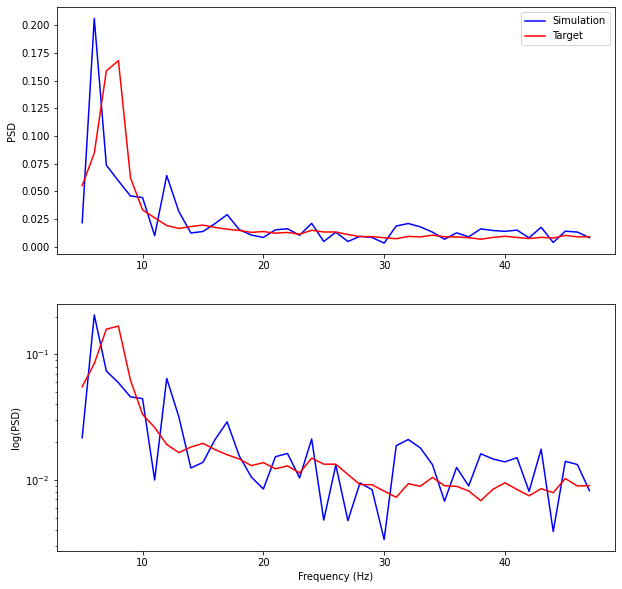

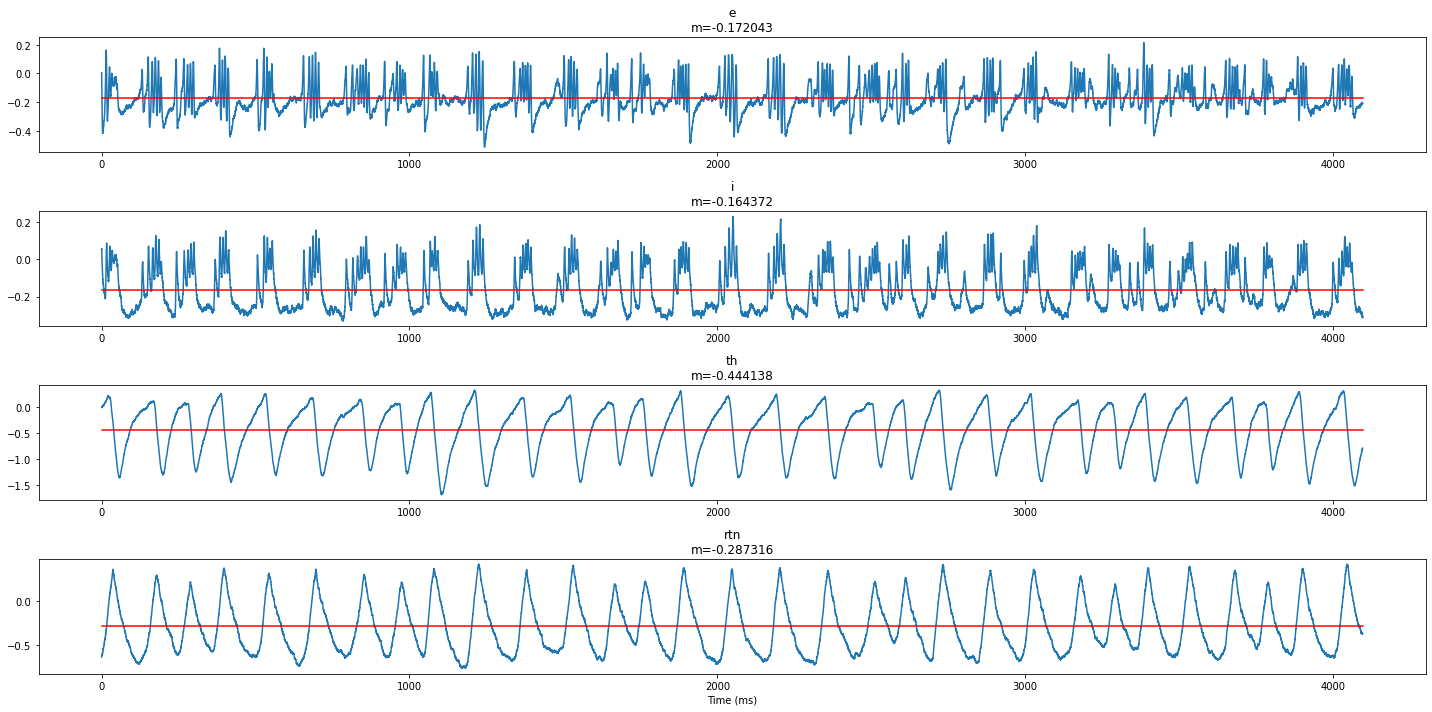

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(2)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 1.5!



Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 58 epochs.Done in 166.573 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


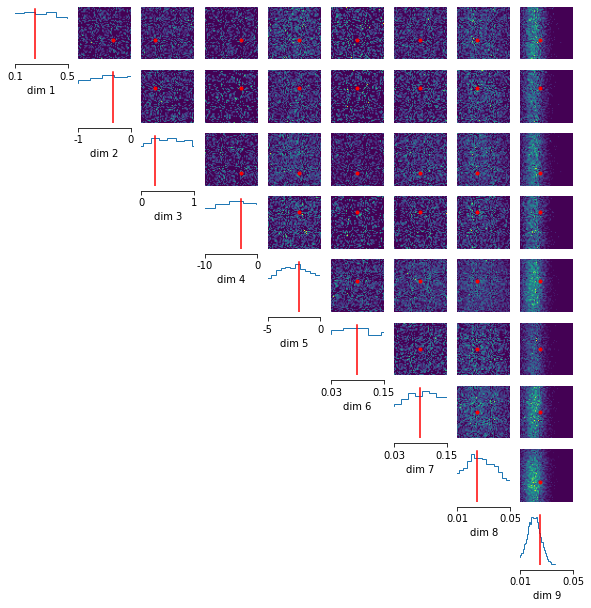

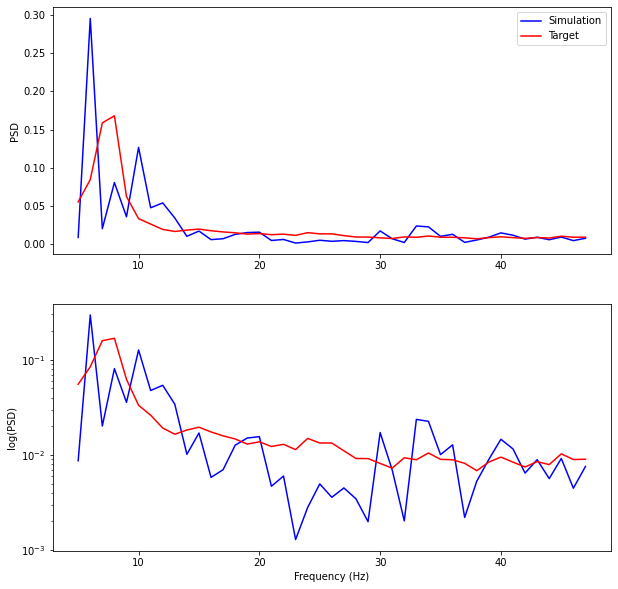

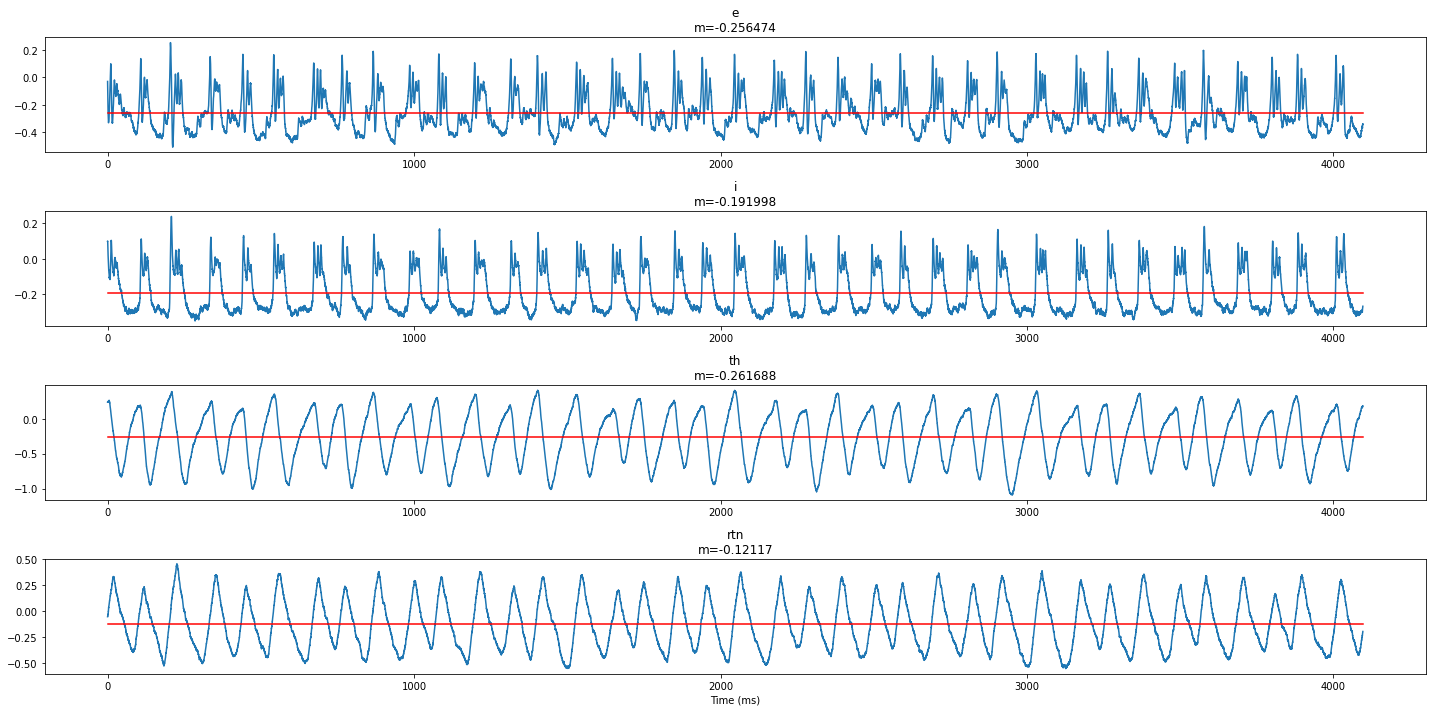

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(3)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 2!



Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 70 epochs.Done in 151.785 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


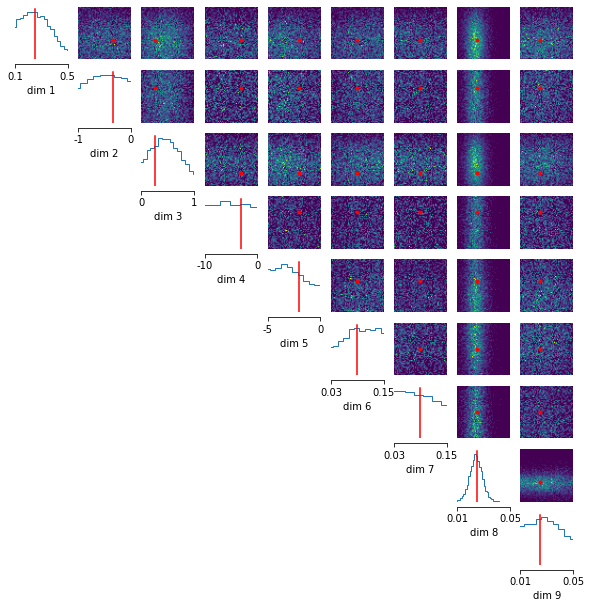

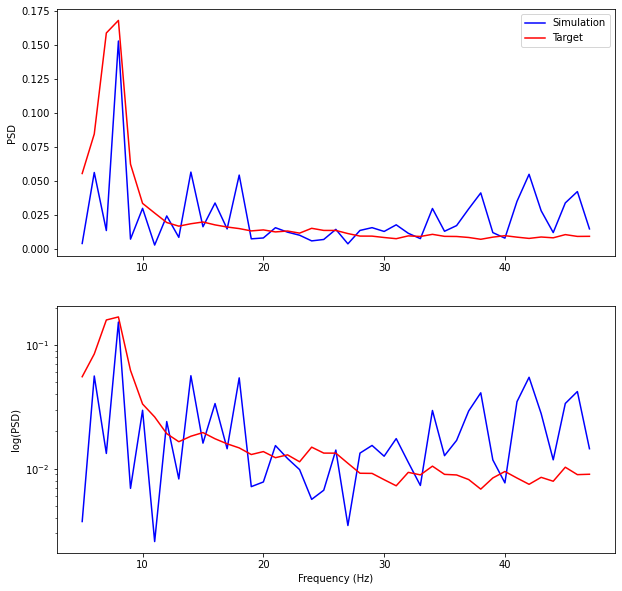

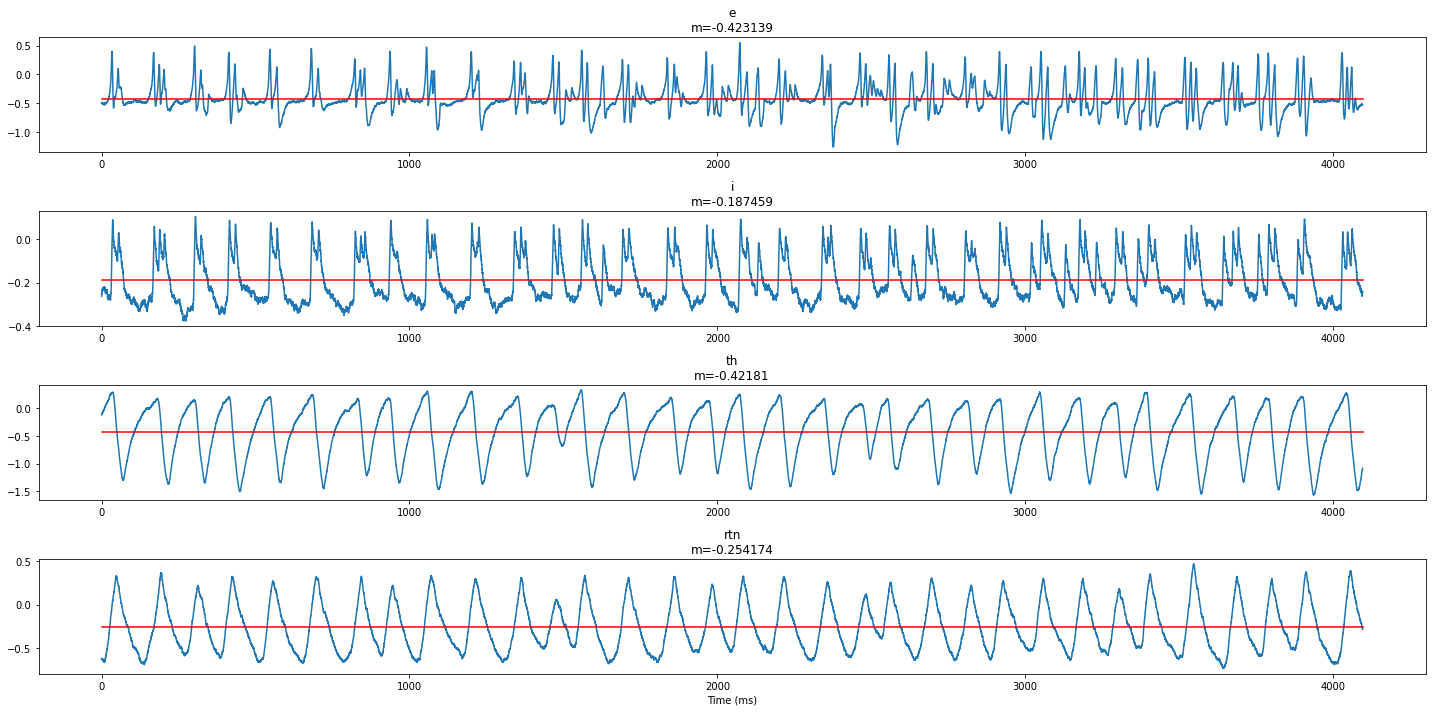

In [ ]:
samples_fit_Gs, figaxes = model_sbi_fit(4)
samples.append(samples_fit_Gs)
figs.append(figaxes)


In [ ]:
samples

[{0.0: {'samples': array([[-0.57584965, -1.6102489 ,  1.3716315 , ...,  0.16157131,
            0.03471509,  0.02721013],
          [-0.2324197 , -0.18616293,  0.9301725 , ...,  0.06872971,
            0.01956894,  0.01442141],
          [-0.00533592, -0.5817503 ,  0.10736711, ...,  0.05872393,
            0.02877957,  0.031282  ],
          ...,
          [ 0.7237324 , -0.3879321 ,  0.6796508 , ...,  0.08025793,
            0.01548264,  0.03075456],
          [ 0.40273887, -1.2422684 ,  1.2832521 , ...,  0.01642363,
            0.0345733 ,  0.01144467],
          [ 0.4303538 , -1.9299989 ,  0.8521388 , ...,  0.18680482,
            0.0302664 ,  0.02655004]], dtype=float32),
   'mean': array([ 0.21611114, -0.492221  ,  0.6936584 , -7.2042727 , -3.0412931 ,
           0.07880134,  0.07985679,  0.02675133,  0.02115505], dtype=float32)},
  0.5: {'samples': array([[ 7.2063249e-01, -2.3382340e-01,  9.7052634e-01, ...,
            2.4555098e-02,  2.8841635e-02,  4.6355318e-02],
          [ 9